In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob

In [3]:
fdir = '/data2/GBT/S140/'

In [4]:
fnamesA = glob.glob(fdir+'Daisy/*/*_03_*A*rfireduced.npz')
fnamesA.sort()
print len(fnamesA)

24


In [5]:
fnames = glob.glob('/data2/GBT/*295/OnOff/*/*_03_*A*rfireduced.npz')
fnames.sort()
print len(fnames)

2


In [6]:
def S295(freqs):
    a0 = 1.4866 
    a1 = -0.7871
    a2 = -0.3440
    a3 = 0.0749
    f = freqs * 1.e-9
    logf = np.log10(f)
    logS = a0 + a1*logf + a2*logf**2 + a3*logf**3
    return 10.**(logS)

In [7]:
def get_freqs_pdiode(k=0, show=True):
    x = np.load(fnames[k])
    y = np.load(fnames[k+1])
    print fnames[k]
    print fnames[k+1]
    if np.any(x['valid'] ^ y['valid']):
        print "CHECK MASK"
    mask = x['valid']
    freqs = x['freqs']

    if x['source'] == 'ON' and y['source'] == 'OFF':
        onSonD = x['xxon']
        onSoffD = x['xxoff']
        offSonD = y['xxon']
        offSoffD = y['xxoff']
    elif x['source'] == 'OFF' and y['source'] == 'ON':
        onSonD = y['xxon']
        onSoffD = y['xxoff']
        offSonD = x['xxon']
        offSoffD = x['xxoff']
    else:
        print "DISASTER"
    
    Psource = S295(freqs)
    gain = np.nanmean(onSoffD[200:,:] - offSoffD[200:,:], 0) / Psource
    Pdiode = np.nanmean(offSonD[200:,:] - offSoffD[200:,:], 0) / gain
    if show:
        figure()
        plot(freqs, np.nanmean(onSonD[200:,mask], 0), label='onSonD')
        plot(freqs, np.nanmean(onSoffD[200:,mask], 0), label='onSoffD')
        plot(freqs, np.nanmean(offSonD[200:,mask], 0), label='offSonD')
        plot(freqs, np.nanmean(offSoffD[200:,mask], 0), label='offSoffD')
        legend()
        figure()
        plot(freqs, Pdiode)
        xlabel('frequency')
        ylabel('Jy')
    return freqs, Pdiode

In [8]:
fdiode, pdiode = get_freqs_pdiode(0, False)

/data2/GBT/3C295/OnOff/scan_03_006.raw.vegas/scan_03_006.raw.vegas.A.fits.rfireduced.npz
/data2/GBT/3C295/OnOff/scan_03_007.raw.vegas/scan_03_007.raw.vegas.A.fits.rfireduced.npz


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice


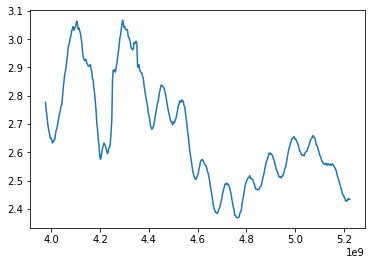

In [9]:
plot(fdiode, pdiode)

In [10]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p, hits, ra_bins, dec_bins

In [11]:
calibratedA = [] 
ras = []
decs = []
gains = []
eles = []
for fname in fnamesA:
    nz = np.load(fname)
    ra = nz['sra']
    dec = nz['sdec']
    mask = nz['valid']
    ele = nz['ELEVATIO']
    calib = np.nanmean((nz['xxoff'] * pdiode / (nz['xxon'] - nz['xxoff']))[:,mask], 1)
    calibratedA = np.concatenate([calibratedA, calib])
    ras = np.concatenate([ras, ra])
    decs = np.concatenate([decs, dec])
    eles = np.concatenate([eles, ele])

(5, 15)

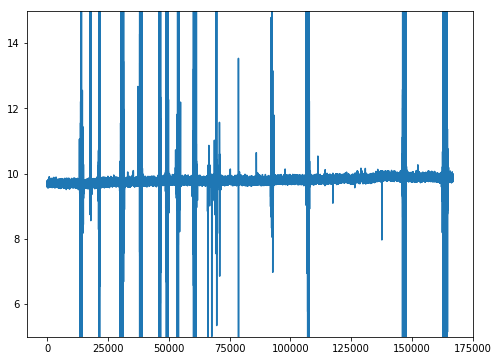

In [17]:
plot(calibratedA)
ylim(5, 15)

In [13]:
datamap, hits, rabins, decbins = naive_map(calibratedA, ras, decs, 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


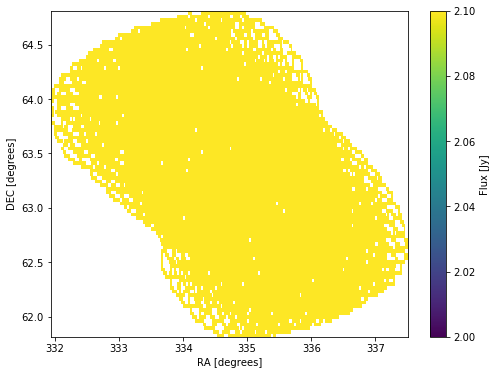

In [14]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(2, 2.1)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

In [18]:
def moving_median(x, N):
    idx = np.arange(N) + np.arange(len(x) - N + 1)[:, None]
    return np.nanmedian(x[idx], axis=1)

In [19]:
mvmed = moving_median(calibratedA, 9)
flat = calibratedA[4:-4] - mvmed

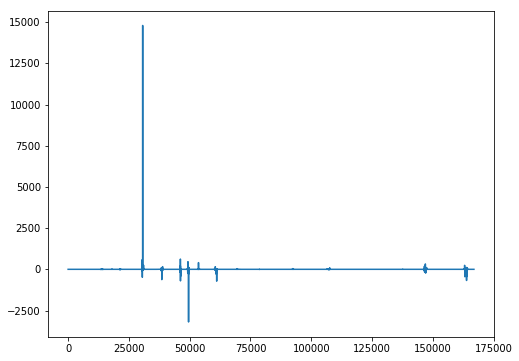

In [20]:
plot(flat)

In [23]:
def mad(x, axis=None):
    return np.nanmedian(np.abs(x - np.nanmedian(x, axis)), axis)

In [25]:
flatmad = mad(flat)

In [32]:
mask = np.abs(flat) > 8 * flatmad

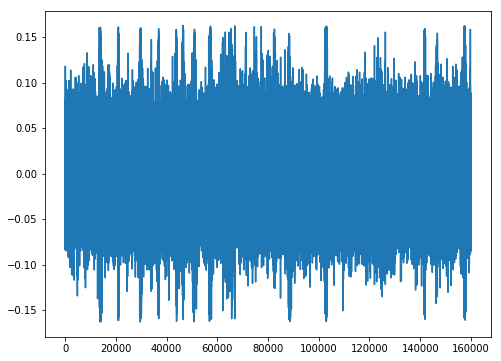

In [33]:
plot(flat[~mask])

In [34]:
ndata = (flat + mvmed)[~mask]

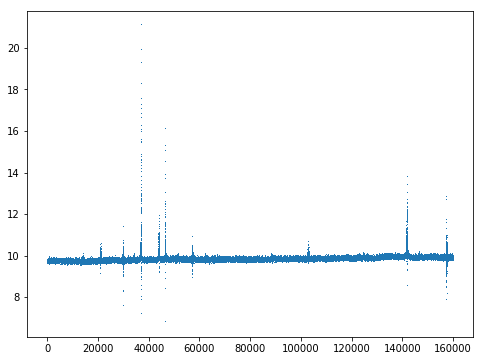

In [35]:
plot(ndata, ',')

In [36]:
t = np.arange(len(ndata))

In [37]:
m = np.sum( (t - np.mean(t))*(ndata - np.mean(ndata)) ) / np.sum( (t - np.mean(t))**2)

In [38]:
b = np.mean(ndata) - m * np.mean(t)

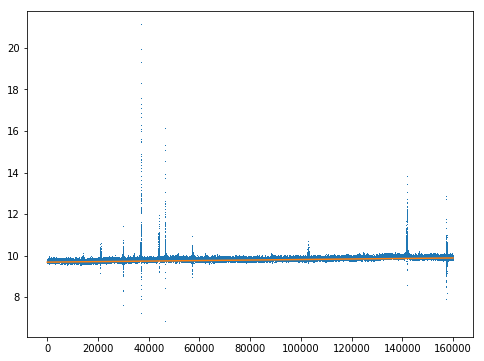

In [39]:
plot(ndata, ',')
plot(m*t +b)

In [40]:
spdata = ndata - (m*t + b)

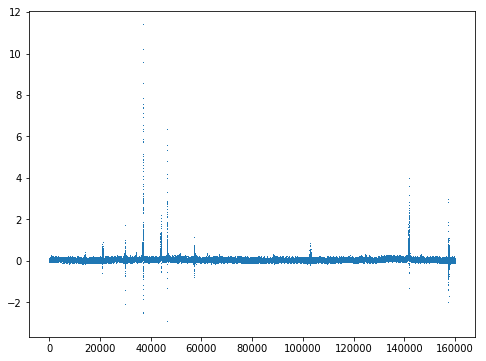

In [41]:
plot(spdata, ',')

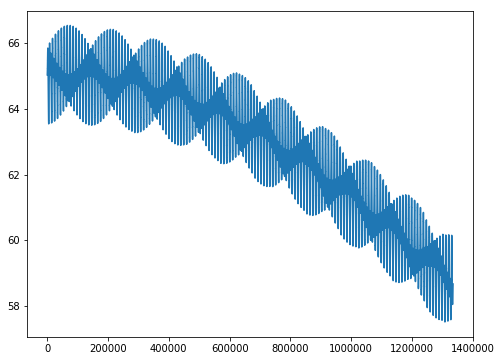

In [42]:
plot(eles)

In [43]:
calibpsd = mlab.psd(calibratedA, NFFT=2**16)

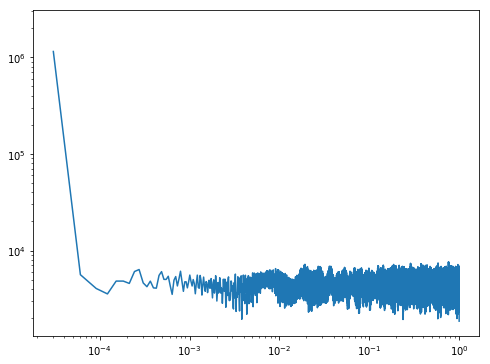

In [44]:
loglog(calibpsd[1], calibpsd[0])

In [45]:
calibpsd = mlab.psd(spdata, NFFT=2**16)

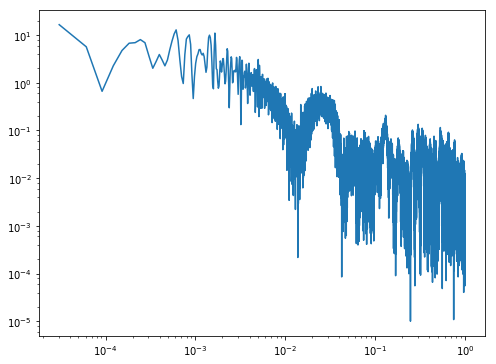

In [46]:
loglog(calibpsd[1], calibpsd[0])

In [48]:
ras = ras[4:-4][~mask]
decs = decs[4:-4][~mask]

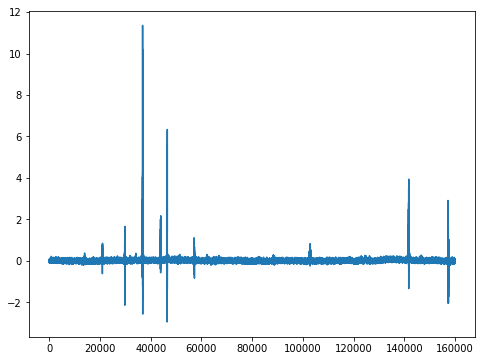

In [49]:
plot(spdata)

In [50]:
datamap, hits, rabins, decbins = naive_map(spdata, ras, decs, 200, 90)
mask = hits == 0
signal = datamap / hits
signal[mask] = np.nan

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


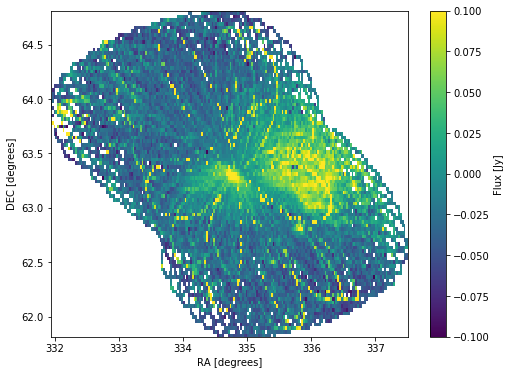

In [52]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.1, 0.1)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')